# Method 8 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

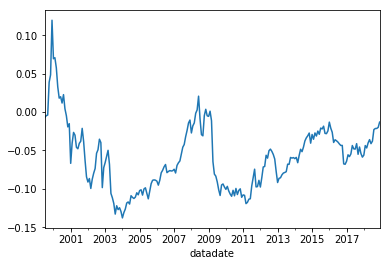

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.119498
2000-12-31   -0.120301
2001-12-31   -0.070269
2002-12-31    0.013061
2003-12-31   -0.061526
2004-12-31    0.024946
2005-12-31    0.021341
2006-12-31    0.013498
2007-12-31    0.071453
2008-12-31    0.005510
2009-12-31   -0.093089
2010-12-31   -0.014865
2011-12-31    0.024847
2012-12-31    0.012771
2013-12-31    0.019509
2014-12-31    0.019936
2015-12-31    0.016596
2016-12-31   -0.044501
2017-12-31    0.009959
2018-12-31    0.048466
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     31.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.62e-21
Time:                        06:29:18   Log-Likelihood:                 729.90
No. Observations:                 234   AIC:                            -1450.
Df Residuals:                     229   BIC:                            -1433.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.159      0.874      -0.002       0.001
mktrf         -0.0221      0.020     -1.094      0.275      -0.062       0.018
me            -0.0335      0.023     -1.430      0.154      -0.080       0.013
ia            -0.2216      0.036     -6.218      0.000      -0.292      -0.151
roe            0.2240      0.031      7.342      0.000       0.164       0.284
==============================================================================
Omnibus:                       66.946   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.957
Skew:                           0.607   Prob(JB):                    4.03e-221
Kurtosis:                      13.130   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     16.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.59e-12
Time:                        06:29:18   Log-Likelihood:                 729.90
No. Observations:                 234   AIC:                            -1450.
Df Residuals:                     229   BIC:                            -1433.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.156      0.876      -0.002       0.001
mktrf         -0.0221      0.023     -0.958      0.338      -0.067       0.023
me            -0.0335      0.034     -0.984      0.325      -0.100       0.033
ia            -0.2216      0.086     -2.569      0.010      -0.391      -0.053
roe            0.2240      0.047      4.727      0.000       0.131       0.317
==============================================================================
Omnibus:                       66.946   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.957
Skew:                           0.607   Prob(JB):                    4.03e-221
Kurtosis:                      13.130   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     15.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.74e-11
Time:                        06:29:18   Log-Likelihood:                 729.90
No. Observations:                 234   AIC:                            -1450.
Df Residuals:                     229   BIC:                            -1433.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.147      0.883      -0.002       0.001
mktrf         -0.0221      0.023     -0.972      0.331      -0.067       0.022
me            -0.0335      0.037     -0.906      0.365      -0.106       0.039
ia            -0.2216      0.077     -2.887      0.004      -0.372      -0.071
roe            0.2240      0.047      4.765      0.000       0.132       0.316
==============================================================================
Omnibus:                       66.946   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1014.957
Skew:                           0.607   Prob(JB):                    4.03e-221
Kurtosis:                      13.130   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     16.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.02e-14
Time:                        06:29:18   Log-Likelihood:                 715.45
No. Observations:                 234   AIC:                            -1419.
Df Residuals:                     228   BIC:                            -1398.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.727      0.468      -0.001       0.002
mktrf         -0.0639      0.022     -2.969      0.003      -0.106      -0.022
smb           -0.0598      0.028     -2.104      0.036      -0.116      -0.004
hml           -0.1117      0.034     -3.334      0.001      -0.178      -0.046
rmw            0.1103      0.038      2.912      0.004       0.036       0.185
cma           -0.1083      0.048     -2.250      0.025      -0.203      -0.013
==============================================================================
Omnibus:                       51.399   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.285
Skew:                           0.122   Prob(JB):                    6.19e-180
Kurtosis:                      12.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     19.86
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.00e-16
Time:                        06:29:18   Log-Likelihood:                 715.45
No. Observations:                 234   AIC:                            -1419.
Df Residuals:                     228   BIC:                            -1398.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.776      0.438      -0.001       0.002
mktrf         -0.0639      0.021     -3.073      0.002      -0.105      -0.023
smb           -0.0598      0.039     -1.534      0.125      -0.136       0.017
hml           -0.1117      0.041     -2.745      0.006      -0.191      -0.032
rmw            0.1103      0.057      1.951      0.051      -0.000       0.221
cma           -0.1083      0.104     -1.038      0.299      -0.313       0.096
==============================================================================
Omnibus:                       51.399   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.285
Skew:                           0.122   Prob(JB):                    6.19e-180
Kurtosis:                      12.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     28.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.34e-22
Time:                        06:29:18   Log-Likelihood:                 715.45
No. Observations:                 234   AIC:                            -1419.
Df Residuals:                     228   BIC:                            -1398.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.725      0.468      -0.001       0.002
mktrf         -0.0639      0.021     -3.108      0.002      -0.104      -0.024
smb           -0.0598      0.036     -1.677      0.093      -0.130       0.010
hml           -0.1117      0.039     -2.867      0.004      -0.188      -0.035
rmw            0.1103      0.060      1.830      0.067      -0.008       0.228
cma           -0.1083      0.106     -1.024      0.306      -0.316       0.099
==============================================================================
Omnibus:                       51.399   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.285
Skew:                           0.122   Prob(JB):                    6.19e-180
Kurtosis:                      12.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     90.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.35e-46
Time:                        06:29:18   Log-Likelihood:                 790.08
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.359      0.720      -0.001       0.001
mktrf          0.0104      0.014      0.725      0.469      -0.018       0.039
smb           -0.1641      0.018     -9.158      0.000      -0.199      -0.129
hml           -0.0976      0.018     -5.485      0.000      -0.133      -0.063
umd            0.1774      0.012     15.194      0.000       0.154       0.200
==============================================================================
Omnibus:                       39.067   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.648
Skew:                           0.194   Prob(JB):                     1.59e-72
Kurtosis:                       8.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     28.65
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.60e-19
Time:                        06:29:18   Log-Likelihood:                 790.08
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.366      0.714      -0.001       0.001
mktrf          0.0104      0.027      0.381      0.703      -0.043       0.064
smb           -0.1641      0.019     -8.657      0.000      -0.201      -0.127
hml           -0.0976      0.025     -3.854      0.000      -0.147      -0.048
umd            0.1774      0.024      7.361      0.000       0.130       0.225
==============================================================================
Omnibus:                       39.067   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.648
Skew:                           0.194   Prob(JB):                     1.59e-72
Kurtosis:                       8.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     26.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.06e-18
Time:                        06:29:18   Log-Likelihood:                 790.08
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.353      0.724      -0.001       0.001
mktrf          0.0104      0.030      0.349      0.727      -0.048       0.069
smb           -0.1641      0.019     -8.438      0.000      -0.202      -0.126
hml           -0.0976      0.026     -3.777      0.000      -0.148      -0.047
umd            0.1774      0.026      6.900      0.000       0.127       0.228
==============================================================================
Omnibus:                       39.067   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.648
Skew:                           0.194   Prob(JB):                     1.59e-72
Kurtosis:                       8.811   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     17.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-11
Time:                        06:29:18   Log-Likelihood:                 350.03
No. Observations:                 120   AIC:                            -690.1
Df Residuals:                     115   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.024      0.308      -0.004       0.001
mktrf          0.0147      0.034      0.425      0.671      -0.054       0.083
me             0.0080      0.034      0.236      0.814      -0.059       0.075
ia            -0.2577      0.053     -4.834      0.000      -0.363      -0.152
roe            0.3028      0.047      6.418      0.000       0.209       0.396
==============================================================================
Omnibus:                       39.467   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.260
Skew:                           0.819   Prob(JB):                     3.77e-61
Kurtosis:                      10.278   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     20.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.17e-13
Time:                        06:29:18   Log-Likelihood:                 350.03
No. Observations:                 120   AIC:                            -690.1
Df Residuals:                     115   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.038      0.299      -0.004       0.001
mktrf          0.0147      0.034      0.425      0.671      -0.053       0.082
me             0.0080      0.039      0.205      0.837      -0.069       0.085
ia            -0.2577      0.108     -2.394      0.017      -0.469      -0.047
roe            0.3028      0.049      6.144      0.000       0.206       0.399
==============================================================================
Omnibus:                       39.467   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.260
Skew:                           0.819   Prob(JB):                     3.77e-61
Kurtosis:                      10.278   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     21.97
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-13
Time:                        06:29:18   Log-Likelihood:                 350.03
No. Observations:                 120   AIC:                            -690.1
Df Residuals:                     115   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.025      0.305      -0.004       0.001
mktrf          0.0147      0.031      0.473      0.636      -0.046       0.075
me             0.0080      0.043      0.188      0.851      -0.076       0.092
ia            -0.2577      0.097     -2.668      0.008      -0.447      -0.068
roe            0.3028      0.041      7.376      0.000       0.222       0.383
==============================================================================
Omnibus:                       39.467   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.260
Skew:                           0.819   Prob(JB):                     3.77e-61
Kurtosis:                      10.278   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.610
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-05
Time:                        06:29:18   Log-Likelihood:                 336.30
No. Observations:                 120   AIC:                            -660.6
Df Residuals:                     114   BIC:                            -643.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.275      0.783      -0.003       0.003
mktrf         -0.0679      0.041     -1.658      0.100      -0.149       0.013
smb           -0.0300      0.046     -0.647      0.519      -0.122       0.062
hml           -0.1346      0.057     -2.369      0.020      -0.247      -0.022
rmw            0.1440      0.067      2.150      0.034       0.011       0.277
cma           -0.1107      0.073     -1.509      0.134      -0.256       0.035
==============================================================================
Omnibus:                       23.717   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.955
Skew:                           0.244   Prob(JB):                     2.74e-33
Kurtosis:                       8.455   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     8.052
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.56e-06
Time:                        06:29:18   Log-Likelihood:                 336.30
No. Observations:                 120   AIC:                            -660.6
Df Residuals:                     114   BIC:                            -643.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.278      0.781      -0.003       0.002
mktrf         -0.0679      0.042     -1.620      0.105      -0.150       0.014
smb           -0.0300      0.054     -0.560      0.576      -0.135       0.075
hml           -0.1346      0.064     -2.111      0.035      -0.260      -0.010
rmw            0.1440      0.074      1.944      0.052      -0.001       0.289
cma           -0.1107      0.128     -0.867      0.386      -0.361       0.140
==============================================================================
Omnibus:                       23.717   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.955
Skew:                           0.244   Prob(JB):                     2.74e-33
Kurtosis:                       8.455   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     12.37
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.37e-09
Time:                        06:29:19   Log-Likelihood:                 336.30
No. Observations:                 120   AIC:                            -660.6
Df Residuals:                     114   BIC:                            -643.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.259      0.795      -0.003       0.003
mktrf         -0.0679      0.042     -1.611      0.107      -0.150       0.015
smb           -0.0300      0.046     -0.653      0.514      -0.120       0.060
hml           -0.1346      0.058     -2.335      0.020      -0.248      -0.022
rmw            0.1440      0.072      2.004      0.045       0.003       0.285
cma           -0.1107      0.129     -0.857      0.391      -0.364       0.142
==============================================================================
Omnibus:                       23.717   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.955
Skew:                           0.244   Prob(JB):                     2.74e-33
Kurtosis:                       8.455   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     57.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-26
Time:                        06:29:19   Log-Likelihood:                 387.08
No. Observations:                 120   AIC:                            -764.2
Df Residuals:                     115   BIC:                            -750.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.470      0.639      -0.002       0.001
mktrf          0.0433      0.022      1.942      0.055      -0.001       0.087
smb           -0.1857      0.025     -7.314      0.000      -0.236      -0.135
hml           -0.1049      0.025     -4.126      0.000      -0.155      -0.055
umd            0.2052      0.016     13.091      0.000       0.174       0.236
==============================================================================
Omnibus:                       15.843   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.336
Skew:                           0.191   Prob(JB):                     3.55e-13
Kurtosis:                       6.365   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     20.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.23e-13
Time:                        06:29:19   Log-Likelihood:                 387.08
No. Observations:                 120   AIC:                            -764.2
Df Residuals:                     115   BIC:                            -750.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.523      0.601      -0.002       0.001
mktrf          0.0433      0.036      1.191      0.234      -0.028       0.115
smb           -0.1857      0.025     -7.470      0.000      -0.234      -0.137
hml           -0.1049      0.030     -3.492      0.000      -0.164      -0.046
umd            0.2052      0.028      7.348      0.000       0.150       0.260
==============================================================================
Omnibus:                       15.843   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.336
Skew:                           0.191   Prob(JB):                     3.55e-13
Kurtosis:                       6.365   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     27.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.57e-16
Time:                        06:29:19   Log-Likelihood:                 387.08
No. Observations:                 120   AIC:                            -764.2
Df Residuals:                     115   BIC:                            -750.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.534      0.594      -0.002       0.001
mktrf          0.0433      0.038      1.125      0.260      -0.032       0.119
smb           -0.1857      0.025     -7.320      0.000      -0.235      -0.136
hml           -0.1049      0.032     -3.318      0.001      -0.167      -0.043
umd            0.2052      0.028      7.413      0.000       0.151       0.260
==============================================================================
Omnibus:                       15.843   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.336
Skew:                           0.191   Prob(JB):                     3.55e-13
Kurtosis:                       6.365   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     22.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.26e-13
Time:                        06:29:19   Log-Likelihood:                 417.98
No. Observations:                 114   AIC:                            -826.0
Df Residuals:                     109   BIC:                            -812.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.832      0.070   -9.43e-05       0.002
mktrf         -0.0462      0.019     -2.483      0.015      -0.083      -0.009
me            -0.1246      0.029     -4.339      0.000      -0.182      -0.068
ia            -0.1499      0.040     -3.764      0.000      -0.229      -0.071
roe            0.0813      0.035      2.323      0.022       0.012       0.151
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.239
Skew:                           0.110   Prob(JB):                        0.888
Kurtosis:                       3.045   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     27.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-15
Time:                        06:29:19   Log-Likelihood:                 417.98
No. Observations:                 114   AIC:                            -826.0
Df Residuals:                     109   BIC:                            -812.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.826      0.068   -8.48e-05       0.002
mktrf         -0.0462      0.019     -2.436      0.015      -0.083      -0.009
me            -0.1246      0.033     -3.800      0.000      -0.189      -0.060
ia            -0.1499      0.049     -3.085      0.002      -0.245      -0.055
roe            0.0813      0.032      2.527      0.011       0.018       0.144
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.239
Skew:                           0.110   Prob(JB):                        0.888
Kurtosis:                       3.045   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     30.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.36e-17
Time:                        06:29:19   Log-Likelihood:                 417.98
No. Observations:                 114   AIC:                            -826.0
Df Residuals:                     109   BIC:                            -812.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.813      0.070   -9.35e-05       0.002
mktrf         -0.0462      0.018     -2.606      0.009      -0.081      -0.011
me            -0.1246      0.032     -3.894      0.000      -0.187      -0.062
ia            -0.1499      0.054     -2.786      0.005      -0.255      -0.044
roe            0.0813      0.029      2.771      0.006       0.024       0.139
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.239
Skew:                           0.110   Prob(JB):                        0.888
Kurtosis:                       3.045   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     22.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.28e-15
Time:                        06:29:19   Log-Likelihood:                 424.35
No. Observations:                 114   AIC:                            -836.7
Df Residuals:                     108   BIC:                            -820.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.043      0.043    3.66e-05       0.002
mktrf         -0.0474      0.017     -2.812      0.006      -0.081      -0.014
smb           -0.1169      0.027     -4.273      0.000      -0.171      -0.063
hml           -0.0711      0.035     -2.037      0.044      -0.140      -0.002
rmw            0.0688      0.043      1.610      0.110      -0.016       0.153
cma           -0.1240      0.054     -2.287      0.024      -0.232      -0.017
==============================================================================
Omnibus:                        0.952   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.582
Skew:                           0.152   Prob(JB):                        0.748
Kurtosis:                       3.174   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     32.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.88e-20
Time:                        06:29:19   Log-Likelihood:                 424.35
No. Observations:                 114   AIC:                            -836.7
Df Residuals:                     108   BIC:                            -820.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.485      0.013       0.000       0.002
mktrf         -0.0474      0.018     -2.609      0.009      -0.083      -0.012
smb           -0.1169      0.025     -4.687      0.000      -0.166      -0.068
hml           -0.0711      0.026     -2.743      0.006      -0.122      -0.020
rmw            0.0688      0.038      1.831      0.067      -0.005       0.142
cma           -0.1240      0.053     -2.331      0.020      -0.228      -0.020
==============================================================================
Omnibus:                        0.952   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.582
Skew:                           0.152   Prob(JB):                        0.748
Kurtosis:                       3.174   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     33.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-20
Time:                        06:29:19   Log-Likelihood:                 424.35
No. Observations:                 114   AIC:                            -836.7
Df Residuals:                     108   BIC:                            -820.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.508      0.012       0.000       0.002
mktrf         -0.0474      0.017     -2.707      0.007      -0.082      -0.013
smb           -0.1169      0.026     -4.496      0.000      -0.168      -0.066
hml           -0.0711      0.023     -3.130      0.002      -0.116      -0.027
rmw            0.0688      0.038      1.806      0.071      -0.006       0.143
cma           -0.1240      0.053     -2.323      0.020      -0.229      -0.019
==============================================================================
Omnibus:                        0.952   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.582
Skew:                           0.152   Prob(JB):                        0.748
Kurtosis:                       3.174   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     33.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.12e-18
Time:                        06:29:19   Log-Likelihood:                 429.90
No. Observations:                 114   AIC:                            -849.8
Df Residuals:                     109   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.525      0.130      -0.000       0.002
mktrf         -0.0381      0.016     -2.401      0.018      -0.070      -0.007
smb           -0.1360      0.025     -5.493      0.000      -0.185      -0.087
hml           -0.1008      0.025     -3.956      0.000      -0.151      -0.050
umd            0.0865      0.019      4.500      0.000       0.048       0.125
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.155
Skew:                           0.005   Prob(JB):                        0.925
Kurtosis:                       2.819   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     34.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-18
Time:                        06:29:19   Log-Likelihood:                 429.90
No. Observations:                 114   AIC:                            -849.8
Df Residuals:                     109   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.915      0.056   -2.04e-05       0.002
mktrf         -0.0381      0.016     -2.391      0.017      -0.069      -0.007
smb           -0.1360      0.028     -4.835      0.000      -0.191      -0.081
hml           -0.1008      0.020     -5.087      0.000      -0.140      -0.062
umd            0.0865      0.017      4.981      0.000       0.052       0.121
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.155
Skew:                           0.005   Prob(JB):                        0.925
Kurtosis:                       2.819   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     36.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.86e-19
Time:                        06:29:19   Log-Likelihood:                 429.90
No. Observations:                 114   AIC:                            -849.8
Df Residuals:                     109   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.216      0.027    9.96e-05       0.002
mktrf         -0.0381      0.014     -2.755      0.006      -0.065      -0.011
smb           -0.1360      0.030     -4.543      0.000      -0.195      -0.077
hml           -0.1008      0.018     -5.736      0.000      -0.135      -0.066
umd            0.0865      0.018      4.727      0.000       0.051       0.122
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.155
Skew:                           0.005   Prob(JB):                        0.925
Kurtosis:                       2.819   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""